In [1]:
pip install matplotlib seaborn


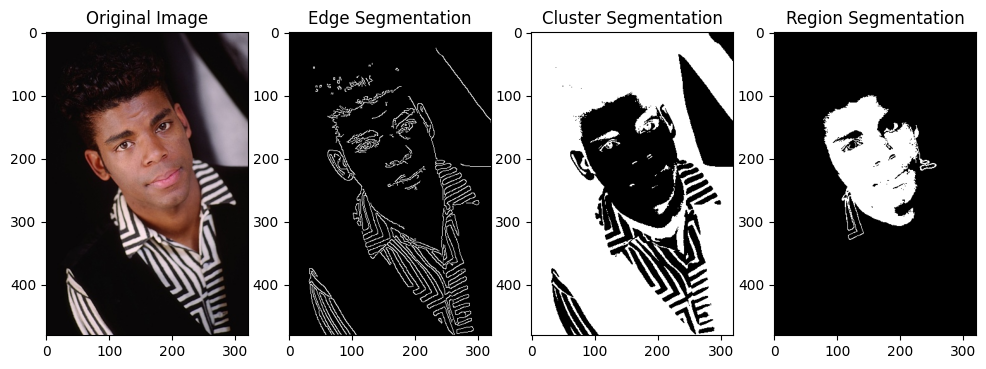

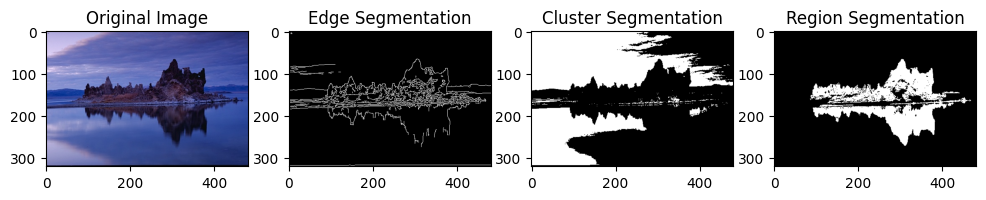

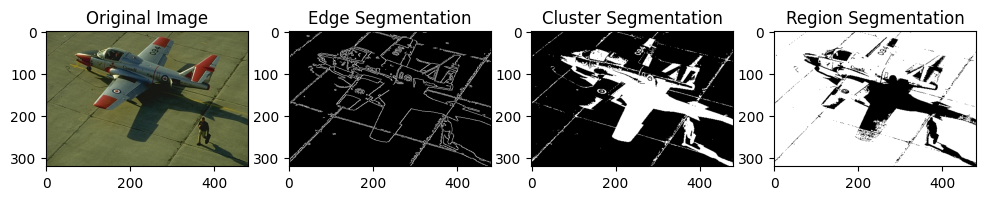

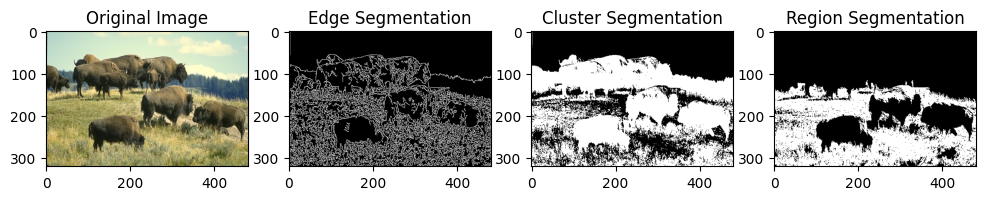

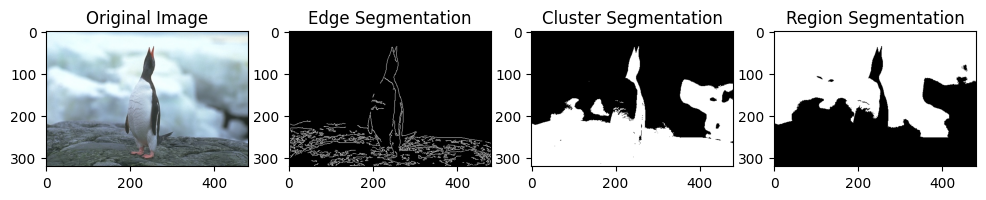

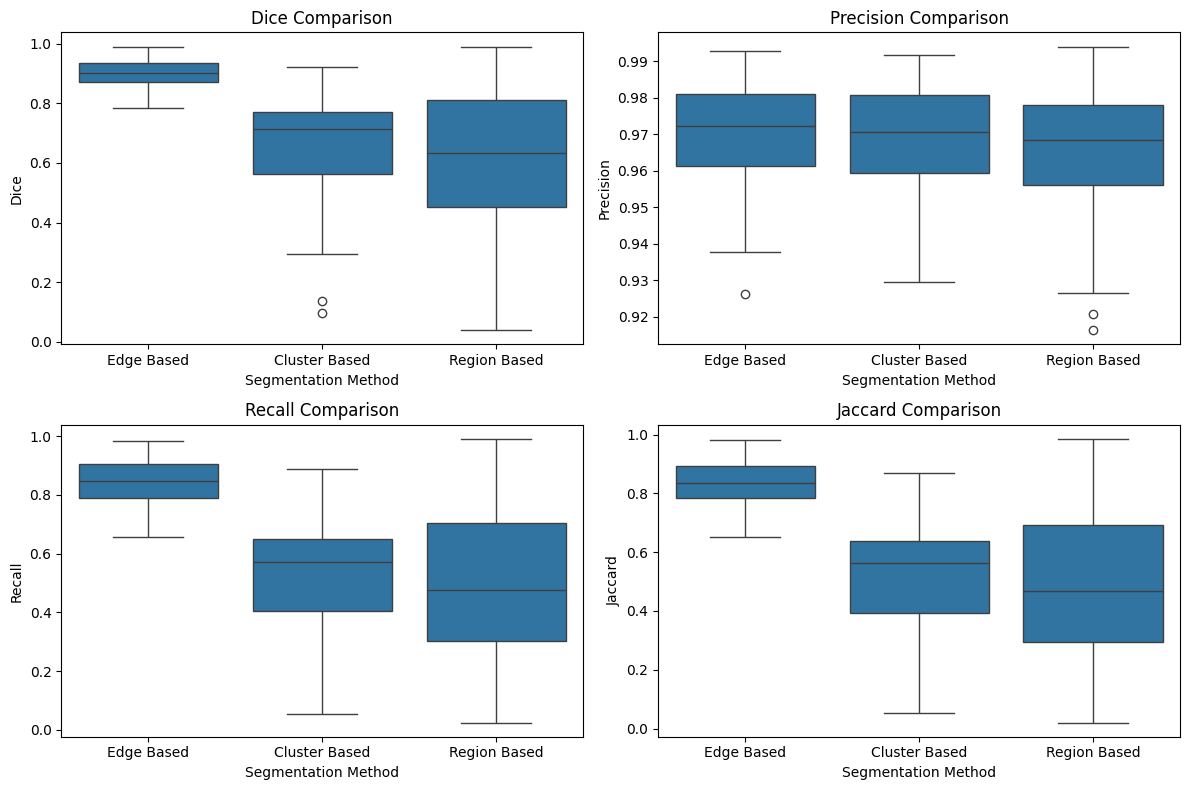

          Image         Method      Dice  Precision    Recall   Jaccard
0    302008.jpg     Edge Based  0.947440   0.966637  0.928990  0.915679
1    302008.jpg  Cluster Based  0.465077   0.960423  0.318023  0.304524
2    302008.jpg   Region Based  0.906596   0.963392  0.857566  0.841660
3    143090.jpg     Edge Based  0.955326   0.974101  0.937261  0.927060
4    143090.jpg  Cluster Based  0.716401   0.966935  0.572419  0.562600
..          ...            ...       ...        ...       ...       ...
295  197017.jpg  Cluster Based  0.562195   0.972571  0.407951  0.393394
296  197017.jpg   Region Based  0.929800   0.967021  0.896834  0.881341
297   42049.jpg     Edge Based  0.948610   0.961450  0.936108  0.920328
298   42049.jpg  Cluster Based  0.876744   0.966426  0.809833  0.791738
299   42049.jpg   Region Based  0.694731   0.947946  0.551376  0.538268

[300 rows x 6 columns]


In [6]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.segmentation import flood
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import io, segmentation
import scipy.io
from scipy.io import loadmat
from sklearn.metrics import f1_score, recall_score, precision_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load ground truth mask from .mat file
def load_ground_truth(mat_path):
    mat_data = scipy.io.loadmat(mat_path)
    ground_truth_data = mat_data['groundTruth']
    # Assuming the first ground truth segmentation is used
    ground_truth_segmentation = ground_truth_data[0][0][0][0]
    ground_truth = ground_truth_segmentation[1]
    return ground_truth


# Function for edge-based segmentation using Canny edge detector
def edge_based_segmentation(image):
    edges = cv2.Canny(image, 100, 200)
    return edges


# Function for clustering-based segmentation using k-means
def clustering_based_segmentation(image, k=2):
    # Convert image to 2D array
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, _ = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 2D image
    segmented_image = labels.reshape((image.shape[:-1]))
    return segmented_image


# Function for region-based segmentation using flood fill
def region_based_segmentation(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply region growing (using flood fill)
    segmented_image = flood(gray, seed_point, tolerance=50).astype(int)
    return segmented_image

# Function to calculate evaluation metrics
def evaluate_segmentation(ground_truth, segmentation_result):
    gt = ground_truth.flatten()
    seg = segmentation_result.flatten()

    dice = f1_score(gt, seg, average='weighted')
    precision = precision_score(gt, seg, average='weighted',zero_division=0)
    recall = recall_score(gt, seg, average='weighted',zero_division=0)
    jaccard = jaccard_score(gt, seg, average='weighted')

    return dice, precision, recall, jaccard

# Function to plot the segmentation outputs images
def plot_segmentation_results(image, edge_segmentation, cluster_segmentation, region_segmentation):
    # Visualize the results
    plt.figure(figsize=(12, 9))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 4, 2)
    plt.title('Edge Segmentation')
    plt.imshow(edge_segmentation, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Cluster Segmentation')
    plt.imshow(cluster_segmentation, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title('Region Segmentation')
    plt.imshow(region_segmentation, cmap='gray')

    plt.show()

def prepre_arr_element (filename, method, metrics):
  return  {
            'Image': filename,
            'Method': method,
            'Dice': metrics[0],
            'Precision': metrics[1],
            'Recall': metrics[2],
            'Jaccard': metrics[3]
          }




# Directory containing images and ground truth masks
image_dir = '/content/Image_Segmentation/images'
ground_truth_dir = '/content/Image_Segmentation/mat'
k_cluster_num = 2


# List to store results
results = []
seed_point = (150, 100)
img_counter = 0

# Loop over all images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        # Get the image and the mat files paths
        image_path = os.path.join(image_dir, filename)
        gt_path = os.path.join(ground_truth_dir, filename.replace('.jpg', '.mat'))

        # Load image and ground truth mask
        image = io.imread(image_path)
        ground_truth = load_ground_truth(gt_path)

        # Perform segmentation using all methods
        edge_segmentation = edge_based_segmentation(image)
        cluster_segmentation = clustering_based_segmentation(image, k_cluster_num)
        region_segmentation = region_based_segmentation(image)

        # Evaluate all segmentations
        edge_metrics = evaluate_segmentation(ground_truth, edge_segmentation)
        cluster_metrics = evaluate_segmentation(ground_truth, cluster_segmentation)
        region_metrics = evaluate_segmentation(ground_truth, region_segmentation)

        #plot the segmentation output images only for the first X images
        if img_counter < 5:
          plot_segmentation_results(image, edge_segmentation, cluster_segmentation, region_segmentation)
          img_counter += 1

        # Store the results into array
        results.append(prepre_arr_element(filename, 'Edge Based', edge_metrics))
        results.append(prepre_arr_element(filename, 'Cluster Based', cluster_metrics))
        results.append(prepre_arr_element(filename, 'Region Based', region_metrics))

# Create a DataFrame to hold the results
df = pd.DataFrame(results)

# Plot the results
metrics = ['Dice', 'Precision', 'Recall', 'Jaccard']
plt.figure(figsize=(12, 8))

for metric in metrics:
    plt.subplot(2, 2, metrics.index(metric) + 1)
    sns.boxplot(x='Method', y=metric, data=df)
    plt.title(f'{metric} Comparison')
    plt.xlabel('Segmentation Method')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# Save results to a CSV file
df.to_csv('segmentation_evaluation_results.csv', index=False)

# Display the results
print(df)
